# Building a Simple Model to Predict Prices

1. Start with no comp viz on the images.
2. First need to figure out what data we actually have on each property and process it into dataframes.
3. Then figure out a basic model for it and start with trying to just predict the listed price? Could help understand the data, which features are useful, and which features need to be embedded/vectorized (e.g. descriptions, nearby schools).
4. Then try some different models out on different partions of the data and see which are helpful in predicting price (in particular, which features have the most alpha).


### An Interesting Idea

What if we tried ranking homes based on their images, and then compare to their actual prices / zillow estimates?

Could also try comparing models that use different data! For example:

- NLP model (word2vec into NN) on the description and other text fields.
- Comp Vis model on the house images.
- Simpler model on simpler data (like square footage, zip code, etc.).
- Using embeddings on schools/nearby neighbourhoods, etc..

### This notebook rn

- Unpacks all the property details, prunes the useless features, multi-hot encodes the categorical features, does some more preprocessing
- Eliminates about 95% of the memory consumption (about 100kb per property now, despite sparse multi-hot encoding on categorical features, like appliances)

In [1]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pympler.asizeof import asized
from process import process_dict, multi_hot_encode

# Remove display limits on pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

%load_ext autoreload
%autoreload 2

In [2]:
BASE_DIR = os.path.join(os.getcwd(), "..", "zillowanalyzer", "Data")

homedata_dir = os.path.join(BASE_DIR, "homedata")
propertydetails_dir = os.path.join(BASE_DIR, "propertydetails")

In [3]:
property_details = []
zips = os.listdir(propertydetails_dir)
for zip in zips:
    zip_dir = os.path.join(propertydetails_dir, zip)
    if not os.path.isdir(zip_dir):
        continue
    property_files = os.listdir(zip_dir)
    for file in property_files:
        file_path = os.path.join(zip_dir, file)
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            property_details.append(data)

og_size = asized(property_details, detail=0).size
print(f"Loaded {len(property_details)} jsons with size: {og_size}")

Loaded 8 jsons with size: 9767680


# Plotting example prices

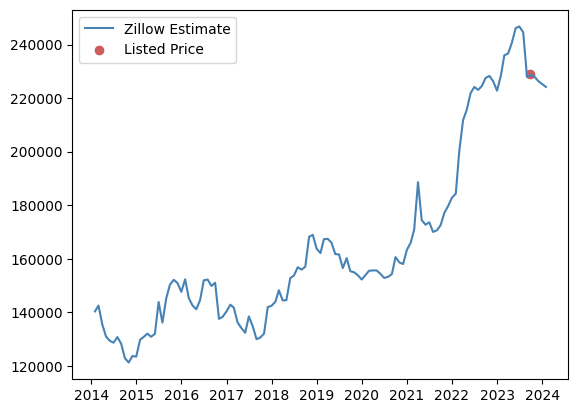

In [4]:
def plot_zestimate_vs_sales(i: int) -> None:
    """
    Plot the zestimate vs any times the property was sold
    or re-listed.
    """
    sample = property_details[i]

    price_hist = pd.DataFrame(
        list(sample["props"]["pageProps"]["componentProps"]["gdpClientCache"].values())[
            0
        ]["property"]["priceHistory"]
    ).drop(["attributeSource"], axis=1)
    price_hist.index = pd.to_datetime(price_hist["time"], unit="ms", utc=True)
    price_hist.sort_index(inplace=True)
    price_hist = price_hist.loc["2000":]  # drop old estimate
    price_hist = price_hist[
        ~price_hist["postingIsRental"]
    ]  # NOTE this also shows rental prices

    zestimate = pd.DataFrame(sample["zestimateHistory"])
    zestimate.index = pd.to_datetime(zestimate["Date"], utc=True)
    zestimate = zestimate["Price"]
    zestimate.sort_index(inplace=True)

    _, ax = plt.subplots()

    ax.plot(zestimate.index, zestimate, label="Zillow Estimate", color="steelblue")
    ax.scatter(
        price_hist.index, price_hist["price"], label="Listed Price", color="indianred"
    )

    ax.legend()
    plt.show()


plot_zestimate_vs_sales(0)

# Process the data into an efficient DF

- Remove a bunch of junk
- Multi-hot encode categorical columns
- (Soon) Create embeddings for more geographical data (e.g. nearby schools).
- (Soon) Create embeddings for free-form text (e.g. listing description).

In [5]:
# First just drop unnecessary cols
trimmed_data = []
for data in property_details:
    trimmed_data.append(process_dict(data))

trimmed_size = asized(trimmed_data, detail=0).size
print(f"Loaded {len(trimmed_data)} jsons with size: {trimmed_size}.")
print(f"Reduced by {(og_size - trimmed_size)/og_size * 100:.2f}%.")

Loaded 8 jsons with size: 486496.
Reduced by 95.02%.


In [6]:
df = pd.json_normalize(trimmed_data)  # un-nest the json

# Basic preprocessing
df.dropna(axis=1, how="all", inplace=True)  # drop all empty cols

print(f"DataFrame with shape {df.shape}.")
df.head()

DataFrame with shape (8, 308).


,listingDataSource,zpid,city,state,homeStatus,isListingClaimedByCurrentSignedInUser,isCurrentSignedInAgentResponsible,bedrooms,bathrooms,price,yearBuilt,streetAddress,zipcode,isCurrentSignedInUserVerifiedOwner,regionString,isRentalListingOffMarket,country,cityId,abbreviatedAddress,county,isUndisclosedAddress,isShowcaseListing,isPremierBuilder,homeType,currency,monthlyHoaFee,livingArea,livingAreaValue,zestimate,zestimateLowPercent,zestimateHighPercent,rentZestimate,restimateLowPercent,restimateHighPercent,countyFIPS,parcelId,description,contingentListingType,timeOnZillow,pageViewCount,favoriteCount,daysOnZillow,latitude,longitude,brokerageName,timeZone,ssid,propertyTaxRate,hdpTypeDimension,mlsid,ouid,propertyTypeDimension,isZillowOwned,listingAccountUserId,buildingId,photoCount,livingAreaUnits,lotSize,lotAreaValue,lotAreaUnits,postingProductType,stateId,zipPlusFour,numberOfUnitsTotal,foreclosureJudicialType,datePostedString,hasBadGeocode,hasPublicVideo,tourViewCount,livingAreaUnitsShort,priceChange,priceChangeDate,priceChangeDateString,hideZestimate,isPreforeclosureAuction,annualHomeownersInsurance,lastSoldPrice,isHousingConnector,isRecentStatusChange,isNonOwnerOccupied,isFeatured,rentalApplicationsAcceptedType,listingTypeDimension,featuredListingTypeDimension,brokerIdDimension,keystoneHomeStatus,isRentalsLeadCapMet,isPaidMultiFamilyBrokerId,countyId,associationFee,associationAmenities,basementYN,buildingName,buyerAgencyCompensation,buyerAgencyCompensationType,appliances,bathroomsFull,bathroomsHalf,bathroomsFloat,canRaiseHorses,carportParkingCapacity,cityRegion,communityFeatures,cooling,coveredParkingCapacity,doorFeatures,electric,entryLocation,flooring,furnished,garageParkingCapacity,hasAssociation,hasAttachedGarage,hasAttachedProperty,hasCooling,hasCarport,hasElectricOnProperty,hasFireplace,hasGarage,hasHeating,hasLandLease,hasOpenParking,hasSpa,hasPrivatePool,hasView,hasWaterfrontView,heating,hoaFee,hoaFeeTotal,horseYN,interiorFeatures,isSeniorCommunity,landLeaseAmount,laundryFeatures,levels,lotFeatures,livingQuarters,mainLevelBathrooms,mainLevelBedrooms,numberOfUnitsInCommunity,onMarketDate,otherFacts,parkingCapacity,parkingFeatures,patioAndPorchFeatures,poolFeatures,pricePerSquareFoot,roofType,securityFeatures,sewer,stories,storiesTotal,subdivisionName,utilities,view,waterSource,waterfrontFeatures,waterView,waterViewYN,windowFeatures,zoning,builderModel,buildingArea,constructionMaterials,exteriorFeatures,foundationDetails,frontageLength,hasAdditionalParcels,hasPetsAllowed,hasHomeWarranty,isNewConstruction,listingTerms,parcelNumber,propertyCondition,propertySubType,structureType,virtualTour,listAOR,fact.Type,fact.Year Built,fact.Heating,fact.Cooling,fact.Parking,fact.HOA,fact.Days on Zillow,fact.Price/sqft,fact.Buyers Agency Fee,address.streetAddress,address.city,address.state,address.zipcode,listing_sub_type.is_forAuction,listing_sub_type.is_newHome,listing_sub_type.is_FSBO,listing_sub_type.is_FSBA,listing_sub_type.is_foreclosure,listing_sub_type.is_bankOwned,listing_sub_type.is_comingSoon,listing_sub_type.is_pending,listing_sub_type.is_openHouse,parentRegion.name,listingMetadata.mustAttributeOfficeNameBeforeAgentName,listingMetadata.mustDisplayAttributionListAgentEmail,listingMetadata.mustDisplayAttributionListAgentPhone,listingMetadata.mustDisplayAttributionListingOfficePhone,listingMetadata.mustDisplayDisclaimerBelowAttribution,listingMetadata.mustHighlightListOfficeName,listingMetadata.mustMakeListingAgentContactable,listingMetadata.FlexibleLayoutAB,listingMetadata.isAdsRestricted,listingMetadata.mustPreferMlsPhotos,listingMetadata.canShowPrequalifiedLinkInChip,listingMetadata.FlexibleLayoutB,listingMetadata.FlexibleLayoutC,listingMetadata.FlexibleLayoutD,listingMetadata.FlexibleLayoutE,listingMetadata.FlexibleLayoutF,listingMetadata.FlexibleLayoutG,listingMetadata.FlexibleLayoutH,listingMetadata.FlexibleLayoutI,listingMetadata.FlexibleLayoutJ,listingMetadata.FlexibleLayoutK,listingMetadata.FlexibleLayoutL,listingMetad

## Apply Multi-Hot Encoding to Categorical Cols

Notice that we lose some of the memory gains because we create a bunch of new (sparse) columns, ideally we may find a more efficient embedding?

**TODO**
- We catch categorical features by finding all cols that were originally arrays. However, there's a few hidden categorical features that are just comma (or space) separated strings of items (e.g. `entryLocation`).
- Still need to one-hot encode other categorical features, like `brokerageName`. Integer encoding would be simple (but stupid) so probs one-hot is better. This would, again, increase dimensionality :(
- Create smart embedding for geographical features (like city, address, etc.) How are these usually represented in learning algs? Would be interesting to have a model that exclusively trains on geographical location (perhaps some kind of graph algo?)

In [7]:
df = multi_hot_encode(df)
multi_hot_size = asized(df, detail=0).size

In [8]:
# Fill NaNs
for col in df.columns:
    try:
        vals = df[col].dropna().unique()
        if all([v in [True, False] for v in vals]):
            df[col] = df[col].fillna(False)
    except TypeError:
        pass  # contains unhashable type

# TODO still need to fill NaNs for other types. How?

/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_35895/2650881826.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False)


In [9]:
# Make sure we got rid of all the nasty types
types = df.dtypes
to_investigate = []
for i, t in enumerate(types):
    col = df.columns[i]
    if t == "object" and type(df.iloc[0, i]) not in [str, type(None)]:
        to_investigate.append(df.columns[i])

if to_investigate:
    print(f"Still some nasty types: {to_investigate}")
    display(df[to_investigate])

# Drop em
df.drop(to_investigate, axis=1, inplace=True)

Still some nasty types: ['bathroomsHalf', 'mainLevelBathrooms', 'mainLevelBedrooms', 'fact.Lot', 'maloneId', 'dateSoldString', 'zestimateMinus30', 'restimateMinus30', 'compsCarouselPropertyPhotos', 'streetView.addressSources', 'streetView.latLongSources', 'NFSHDPTopSlot.eventId', 'NFSHDPTopSlot.messages', 'NFSHDPBottomSlot.eventId', 'NFSHDPBottomSlot.messages', 'homeValuation.comparables.comps']


,bathroomsHalf,mainLevelBathrooms,mainLevelBedrooms,fact.Lot,maloneId,dateSoldString,zestimateMinus30,restimateMinus30,compsCarouselPropertyPhotos,streetView.addressSources,streetView.latLongSources,NFSHDPTopSlot.eventId,NFSHDPTopSlot.messages,NFSHDPBottomSlot.eventId,NFSHDPBottomSlot.messages,homeValuation.comparables.comps
0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,False,False,"3,699 sqft",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,False,False,False,NaN,2093347848,1992-03-01,282190,2299,[{'mixedSources': {'jpeg': [{'url': 'https://m...,"[{'width': 192, 'url': 'https://maps.googleapi...","[{'width': 192, 'url': 'https://maps.googleapi...",0ff37b23-1f39-443c-bcc7-ecf926b4e53f,"[{'skipDisplayReason': None, 'shouldDisplay': ...",0ff37b23-1f39-443c-bcc7-ecf926b4e53f,"[{'skipDisplayReason': None, 'shouldDisplay': ...","[{'property': {'zestimate': 249000, 'lastSoldP..."
6,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print(f"Ultimately, DataFrame with shape {df.shape} and size {multi_hot_size}.")
df.head()

Ultimately, DataFrame with shape (8, 356) and size 818816.


,listingDataSource,zpid,city,state,homeStatus,isListingClaimedByCurrentSignedInUser,isCurrentSignedInAgentResponsible,bedrooms,bathrooms,price,yearBuilt,streetAddress,zipcode,isCurrentSignedInUserVerifiedOwner,regionString,isRentalListingOffMarket,country,cityId,abbreviatedAddress,county,isUndisclosedAddress,isShowcaseListing,isPremierBuilder,homeType,currency,monthlyHoaFee,livingArea,livingAreaValue,zestimate,zestimateLowPercent,zestimateHighPercent,rentZestimate,restimateLowPercent,restimateHighPercent,countyFIPS,parcelId,description,contingentListingType,timeOnZillow,pageViewCount,favoriteCount,daysOnZillow,latitude,longitude,brokerageName,timeZone,ssid,propertyTaxRate,hdpTypeDimension,mlsid,ouid,propertyTypeDimension,isZillowOwned,listingAccountUserId,buildingId,photoCount,livingAreaUnits,lotSize,lotAreaValue,lotAreaUnits,postingProductType,stateId,zipPlusFour,numberOfUnitsTotal,foreclosureJudicialType,datePostedString,hasBadGeocode,hasPublicVideo,tourViewCount,livingAreaUnitsShort,priceChange,priceChangeDate,priceChangeDateString,hideZestimate,isPreforeclosureAuction,annualHomeownersInsurance,lastSoldPrice,isHousingConnector,isRecentStatusChange,isNonOwnerOccupied,isFeatured,rentalApplicationsAcceptedType,listingTypeDimension,featuredListingTypeDimension,brokerIdDimension,keystoneHomeStatus,isRentalsLeadCapMet,isPaidMultiFamilyBrokerId,countyId,associationFee,associationAmenities,basementYN,buildingName,buyerAgencyCompensation,buyerAgencyCompensationType,bathroomsFull,bathroomsFloat,canRaiseHorses,carportParkingCapacity,cityRegion,coveredParkingCapacity,doorFeatures,electric,entryLocation,furnished,garageParkingCapacity,hasAssociation,hasAttachedGarage,hasAttachedProperty,hasCooling,hasCarport,hasElectricOnProperty,hasFireplace,hasGarage,hasHeating,hasLandLease,hasOpenParking,hasSpa,hasPrivatePool,hasView,hasWaterfrontView,hoaFee,hoaFeeTotal,horseYN,isSeniorCommunity,landLeaseAmount,levels,numberOfUnitsInCommunity,onMarketDate,parkingCapacity,pricePerSquareFoot,roofType,stories,storiesTotal,subdivisionName,utilities,waterView,waterViewYN,zoning,builderModel,buildingArea,frontageLength,hasAdditionalParcels,hasPetsAllowed,hasHomeWarranty,isNewConstruction,listingTerms,parcelNumber,propertyCondition,structureType,virtualTour,listAOR,fact.Type,fact.Year Built,fact.Heating,fact.Cooling,fact.Parking,fact.HOA,fact.Days on Zillow,fact.Price/sqft,fact.Buyers Agency Fee,address.streetAddress,address.city,address.state,address.zipcode,listing_sub_type.is_forAuction,listing_sub_type.is_newHome,listing_sub_type.is_FSBO,listing_sub_type.is_FSBA,listing_sub_type.is_foreclosure,listing_sub_type.is_bankOwned,listing_sub_type.is_comingSoon,listing_sub_type.is_pending,listing_sub_type.is_openHouse,parentRegion.name,listingMetadata.mustAttributeOfficeNameBeforeAgentName,listingMetadata.mustDisplayAttributionListAgentEmail,listingMetadata.mustDisplayAttributionListAgentPhone,listingMetadata.mustDisplayAttributionListingOfficePhone,listingMetadata.mustDisplayDisclaimerBelowAttribution,listingMetadata.mustHighlightListOfficeName,listingMetadata.mustMakeListingAgentContactable,listingMetadata.FlexibleLayoutAB,listingMetadata.isAdsRestricted,listingMetadata.mustPreferMlsPhotos,listingMetadata.canShowPrequalifiedLinkInChip,listingMetadata.FlexibleLayoutB,listingMetadata.FlexibleLayoutC,listingMetadata.FlexibleLayoutD,listingMetadata.FlexibleLayoutE,listingMetadata.FlexibleLayoutF,listingMetadata.FlexibleLayoutG,listingMetadata.FlexibleLayoutH,listingMetadata.FlexibleLayoutI,listingMetadata.FlexibleLayoutJ,listingMetadata.FlexibleLayoutK,listingMetadata.FlexibleLayoutL,listingMetadata.FlexibleLayoutM,listingMetadata.FlexibleLayoutN,listingMetadata.FlexibleLayoutO,listingMetadata.FlexibleLayoutP,listingMetadata.FlexibleLayoutQ,listingMetadata.FlexibleLayoutR,listingMetadata.FlexibleLayoutS,listingMetadata.FlexibleLayoutT,listingMetadata.FlexibleLayoutU,listingMetadata.FlexibleLayoutV,listingMetadata.FlexibleLayoutW,listingMetadata.FlexibleLayoutX,li

In [11]:
nans = df.isna().sum()
nans = nans[nans > 0]
nans

regionString                                           1
monthlyHoaFee                                          1
contingentListingType                                  7
timeOnZillow                                           1
pageViewCount                                          1
favoriteCount                                          1
brokerageName                                          1
ssid                                                   1
mlsid                                                  1
ouid                                                   1
listingAccountUserId                                   1
buildingId                                             1
lotSize                                                7
lotAreaValue                                           4
postingProductType                                     1
zipPlusFour                                            1
numberOfUnitsTotal                                     7
foreclosureJudicialType        

In [12]:
df.shape

(8, 356)

# Train a simple model to better understand features

E.g. Decision tree or RF.

Focus on:
- Are there any features that expose the label (e.g. sqft * price/sqft)
- How many features seem useless and we can drop them?

Since there's still some processing TODOs (e.g. one-hot encoding, filling nans), maybe we could skip ahead for a bit and try building a model just on the non-empty, numeric cols? Like a simple RF to help us identify which features are useful, or maybe something even simpler like PCA.

In [13]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train, y_train = train.drop("price", axis=1), train["price"]
X_test, y_test = test.drop("price", axis=1), test["price"]

# Home Data

Not as useful, basically all of it is contained in the property data.

In [14]:
# # Just one sample for now
# with open(os.path.join(homedata_dir, "33004", "listings_page_1.json")) as f:
#     home_data = json.load(f)

# # Pre-process
# for sample in home_data:
#     del sample["carouselPhotos"]  # for now
#     for k, v in sample["hdpData"]["homeInfo"].items():  # unpack
#         sample[k] = v
#     del sample["hdpData"]

# df = pd.DataFrame(home_data)
# df.head()